In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import meta_Koopman_PINN_surrogate as MKPS
import PipeNet as PN

from pyswmm import Simulation, Links, Nodes, SystemStats
from swmm_api import read_out_file, read_inp_file
from swmm_api.input_file.sections.others import TimeseriesData
from swmm_api.input_file.section_labels import TIMESERIES

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 管网数据结构（组织数据）

In [3]:
# 案例管网
# 通过SWMM生成
inp = read_inp_file('./SWMM/chaohu.inp')

nodes_id = []
for it in inp.JUNCTIONS:
    nodes_id.append(it)

nodes_z,nodes_hfull={},{}
for name in nodes_id:
    nodes_z[name]=inp.JUNCTIONS[name].elevation
    nodes_hfull[name]=inp.JUNCTIONS[name].depth_max

# outfall
for it in inp.OUTFALLS:
    nodes_id.append(it)
    nodes_z[it]=inp.OUTFALLS[it].elevation
    nodes_hfull[it]=inp.OUTFALLS[it].elevation

# storage
for it in inp.STORAGE:
    nodes_id.append(it)
    nodes_z[it]=inp.STORAGE[it].elevation
    nodes_hfull[it]=inp.STORAGE[it].depth_max


links_id=[]
for it in inp.CONDUITS:
    links_id.append(it)

links_xsects = {}
connection = {}
for name in links_id:
    yFull = inp.XSECTIONS['1'].height
    aFull = np.power(yFull/2,2)*np.pi
    rFull = aFull/(np.pi*yFull)
    length = inp.CONDUITS['1'].length
    sigma = inp.CONDUITS['1'].roughness
    links_xsects[name]=PN.section_single(yFull,rFull,aFull,length,sigma)
    connection[name] = (inp.CONDUITS[name].from_node,inp.CONDUITS[name].to_node)

node_connection={}
for name in nodes_id:
    node_connection[name]=[]
    for linkname in links_id:
        if (name in connection[linkname]) and (linkname not in node_connection[name]):
            node_connection[name].append(linkname)

MyNet = PN.Pipe_Network(links_id,links_xsects,nodes_id,nodes_z,nodes_hfull,connection,node_connection)

# 准备节点和管段数据

In [4]:
# qah model training data
linkdata = np.load('./SWMM_DATA/SWMM_linkdata0.npy',allow_pickle=True).tolist()
nodedata = np.load('./SWMM_DATA/SWMM_nodedata0.npy',allow_pickle=True).tolist()
pumpdata = np.load('./SWMM_DATA/SWMM_pumpdata0.npy',allow_pickle=True).tolist()
T, n = 479, len(links_id)

In [5]:
# 以单个单元为对象组织数据
q_input, q_output = [], []
a_input, a_output = [], []

for linkid in links_id:
    h1 = np.array(nodedata[MyNet.connection[str(linkid)][0]]['node_depth'][:-1])
    h2 = np.array(nodedata[MyNet.connection[str(linkid)][1]]['node_depth'][:-1])
    qlast = np.array(linkdata[str(linkid)]['link_flow'][:-1])
    aold = np.array(linkdata[str(linkid)]['link_volume'][:-1])
    aout = np.array(linkdata[str(linkid)]['link_volume'][1:])
    qout = np.array(linkdata[str(linkid)]['link_flow'][1:])
    h1_out = np.array(nodedata[MyNet.connection[str(linkid)][0]]['node_depth'][1:])
    h2_out = np.array(nodedata[MyNet.connection[str(linkid)][1]]['node_depth'][1:])
    z1,z2,length,sigma,dt,yfull,rfull,afull = [],[],[],[],[],[],[],[]
    for t in range(T):
        z1.append([MyNet.nodes.nodes_z[MyNet.connection[str(linkid)][0]]])
        z2.append([MyNet.nodes.nodes_z[MyNet.connection[str(linkid)][1]]])
        length.append([MyNet.links.xsect[str(linkid)].length])
        sigma.append([MyNet.links.xsect[str(linkid)].sigma])
        dt.append([0.01])
        yfull.append([MyNet.links.xsect[str(linkid)].yFull])
        afull.append([MyNet.links.xsect[str(linkid)].aFull])
        rfull.append([MyNet.links.xsect[str(linkid)].rFull])
    
    z1,z2,length,sigma,dt,yfull,afull,rfull = np.array(z1),np.array(z2),np.array(length),np.array(sigma),np.array(dt),np.array(yfull),np.array(afull),np.array(rfull)
    
    q_input += np.concatenate([h1, z1, h2, z2, length, sigma, aold, aold, qlast, dt, yfull, afull, rfull],axis=1).tolist()
    q_output += qout.tolist()
    a_input += np.concatenate([h1, z1, h2, z2, aold, qlast, dt, yfull, afull],axis=1).tolist()
    a_output += aout.tolist()

q_input, q_output = np.array(q_input), np.array(q_output)
a_input, a_output = np.array(a_input), np.array(a_output)

print(q_input.shape, q_output.shape, a_input.shape, a_output.shape)

(70892, 13) (70892, 1) (70892, 9) (70892, 1)


In [6]:
# 以单元为主组织数据
h_input,h_output=[],[]

#h, z, delt_q, a1, a2, dt, hFull)

for nodeid in nodedata.keys():
    z, deltq, dt, hfull, h0, ht = [], [], [], [], [], []
    for t in range(T-1):
        z.append(MyNet.nodes.nodes_z[nodeid])
        qtotal = 0.0
        for linkid in MyNet.node_connection[nodeid]:
            qtotal += linkdata[str(linkid)]['link_flow'][t][0]
        deltq.append(qtotal)
        dt.append([0.01])
        hfull.append(nodes_hfull[nodeid])
        h0.append(nodedata[nodeid]['node_depth'][t][0])
        ht.append(nodedata[nodeid]['node_depth'][t+1][0])
    
    h0, z, deltq, dt, hfull, ht = np.array(h0).reshape((T-1,1)), np.array(z).reshape((T-1,1)), np.array(deltq).reshape((T-1,1)), np.array(dt).reshape((T-1,1)), np.array(hfull).reshape((T-1,1)),np.array(ht).reshape((T-1,1))

    h_input += np.concatenate([h0, z, deltq, dt, hfull],axis=1).tolist()
    h_output += ht.tolist()

h_input, h_output = np.array(h_input), np.array(h_output)
print(h_input.shape, h_output.shape)

(73612, 5) (73612, 1)


# 将网络分为两个部分，计算amid, q, h

## 模型训练

In [7]:
parama = {
    'alayer':(7, 1, 30, 10),
    'wlayer':(2, 1, 30, 10)
}

paramq={
        'wlayer': (2, 1, 30, 10),
        'rlayer': (3, 1, 30, 10),
        'alayer': (4, 1, 30, 10),
        'vlayer': (2, 1, 30, 10),

        'dq1layer': (2, 1, 30, 10),
        'dq2layer': (4, 1, 30, 10),
        'dq3layer': (4, 1, 30, 10),
        'dq4layer': (4, 1, 30, 10),
        'dq5layer': (4, 1, 30, 10),
        'dq6layer': (2, 1, 30, 10),
        'qlayer':(7, 1, 30, 10),
}

paramh = {
    'hlayer':(4, 1, 5, 10),
}

modelaq = MKPS.iter_surrogate_aq(parama,paramq).to(device)
modelh = MKPS.meta_surrogate_h(paramh).to(device)

train_loss_aq=[]
train_loss_h=[]

In [ ]:
#读取
modelaq = torch.load('./surrogate_model/swmm_surogate_v2_step2')
modelh = torch.load('./surrogate_model/swmm_h_surogate_v1_step5')

In [8]:
#criterion = nn.MSELoss()
def my_mse_loss_aq(q,qbar,a,abar):
    #return torch.mean(torch.pow((q-qbar),2)+torch.pow((a-abar),2))
    #r = torch.mean(torch.pow((a[1]-abar),2)) + torch.mean(torch.pow((q[1]-qbar),2))
    #for i in range(2,len(a)):
    #    r += torch.mean(torch.pow((a[i]-abar),2)) + torch.mean(torch.pow((q[i]-qbar),2))
    return torch.mean(torch.pow((a[-1]-abar),2)) + 100 * torch.mean(torch.pow((q[-1]-qbar),2)).to(device)

train_round = 1
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
optimizera = optim.Adam(modelaq.parameters(), lr = 0.1)
for epoch in range(5000):
    if np.mod(epoch,500)==0 and epoch != 0:
        print(epoch,train_loss_aq[-1])   
    a, q = modelaq(torch.tensor(q_input[0:100:2,0]).to(device), 
                torch.tensor(q_input[0:100:2,1]).to(device), 
                torch.tensor(q_input[0:100:2,2]).to(device), 
                torch.tensor(q_input[0:100:2,3]).to(device),
                torch.tensor(q_input[0:100:2,4]).to(device), 
                torch.tensor(q_input[0:100:2,5]).to(device),
                torch.tensor(q_input[0:100:2,7]).to(device),
                torch.tensor(q_input[0:100:2,8]).to(device), 
                torch.tensor(q_input[0:100:2,9]).to(device), 
                torch.tensor(q_input[0:100:2,10]).to(device),
                torch.tensor(q_input[0:100:2,11]).to(device),
                torch.tensor(q_input[0:100:2,12]).to(device))
    
    loss = my_mse_loss_aq(q,torch.tensor(q_output[0:100:2,:]).float().view(-1,1).to(device),a,torch.tensor(a_output[0:100:2,:]).float().view(-1,1).to(device))
    # 反向传播
    optimizera.zero_grad()
    loss.backward()
    optimizera.step()
    
    # 记录误差
    train_loss_aq.append(loss.item())
    #保存
    torch.save(modelaq, './surrogate_model/swmm_surogate_v2_step')
    np.save('./surrogate_model/train_loss_v2'+str(train_round)+'.npy',train_loss_aq)
    #读取
    #the_model = torch.load(PATH)

500 32778.7265625
1000 32778.7265625
1500 32778.7265625
2000 32778.7265625


KeyboardInterrupt: 

In [ ]:
#criterion = nn.MSELoss()
def my_mse_loss_h(h,hbar):
    #return torch.mean(torch.pow((q-qbar),2)+torch.pow((a-abar),2))
    #r = torch.mean(torch.pow((a[1]-abar),2)) + torch.mean(torch.pow((q[1]-qbar),2))
    #for i in range(2,len(a)):
    #    r += torch.mean(torch.pow((a[i]-abar),2)) + torch.mean(torch.pow((q[i]-qbar),2))
    return torch.mean(torch.pow((h-hbar),2))

train_round = 5
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
optimizerh = optim.Adam(modelh.parameters(), lr = 0.01)
for epoch in range(50000):
    if np.mod(epoch,1000)==0 and epoch != 0:
        print(epoch,train_loss_h[-1])   
    h = modelh(torch.tensor(h_input[:500,0]).to(device), 
               torch.tensor(h_input[:500,1]).to(device), 
               torch.tensor(h_input[:500,2]).to(device), 
               torch.tensor(h_input[:500,3]).to(device),
               torch.tensor(h_input[:500,4]).to(device))
    loss = my_mse_loss_h(h,torch.tensor(h_output[:500,:]).float().view(-1,1).to(device))
    # 反向传播
    optimizerh.zero_grad()
    loss.backward()
    optimizerh.step()
    
    # 记录误差
    train_loss_h.append(loss.item())
    #保存
    torch.save(modelh, './surrogate_model/swmm_h_surogate_v1_step'+str(train_round))
    np.save('./surrogate_model/train_loss_v1.npy',train_loss_h)
    #读取
    #the_model = torch.load(PATH)

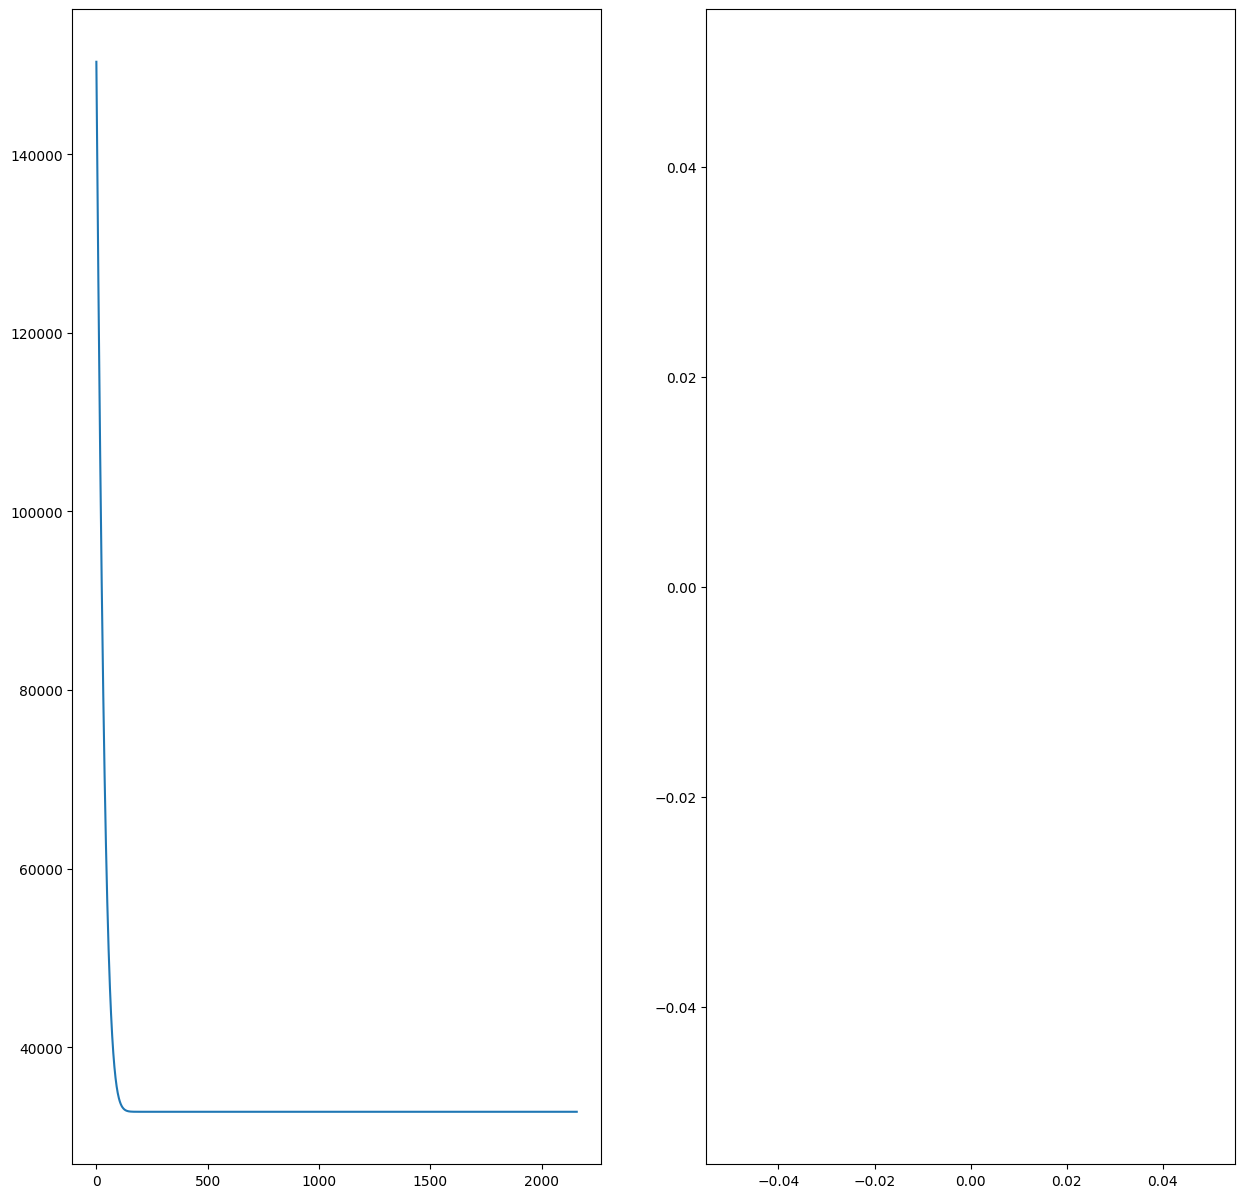

In [9]:
fig,ax = plt.subplots(1,2,figsize=(15,15))
ax[0].plot(train_loss_aq,label='AQ training')
ax[1].plot(train_loss_h,label='H training')

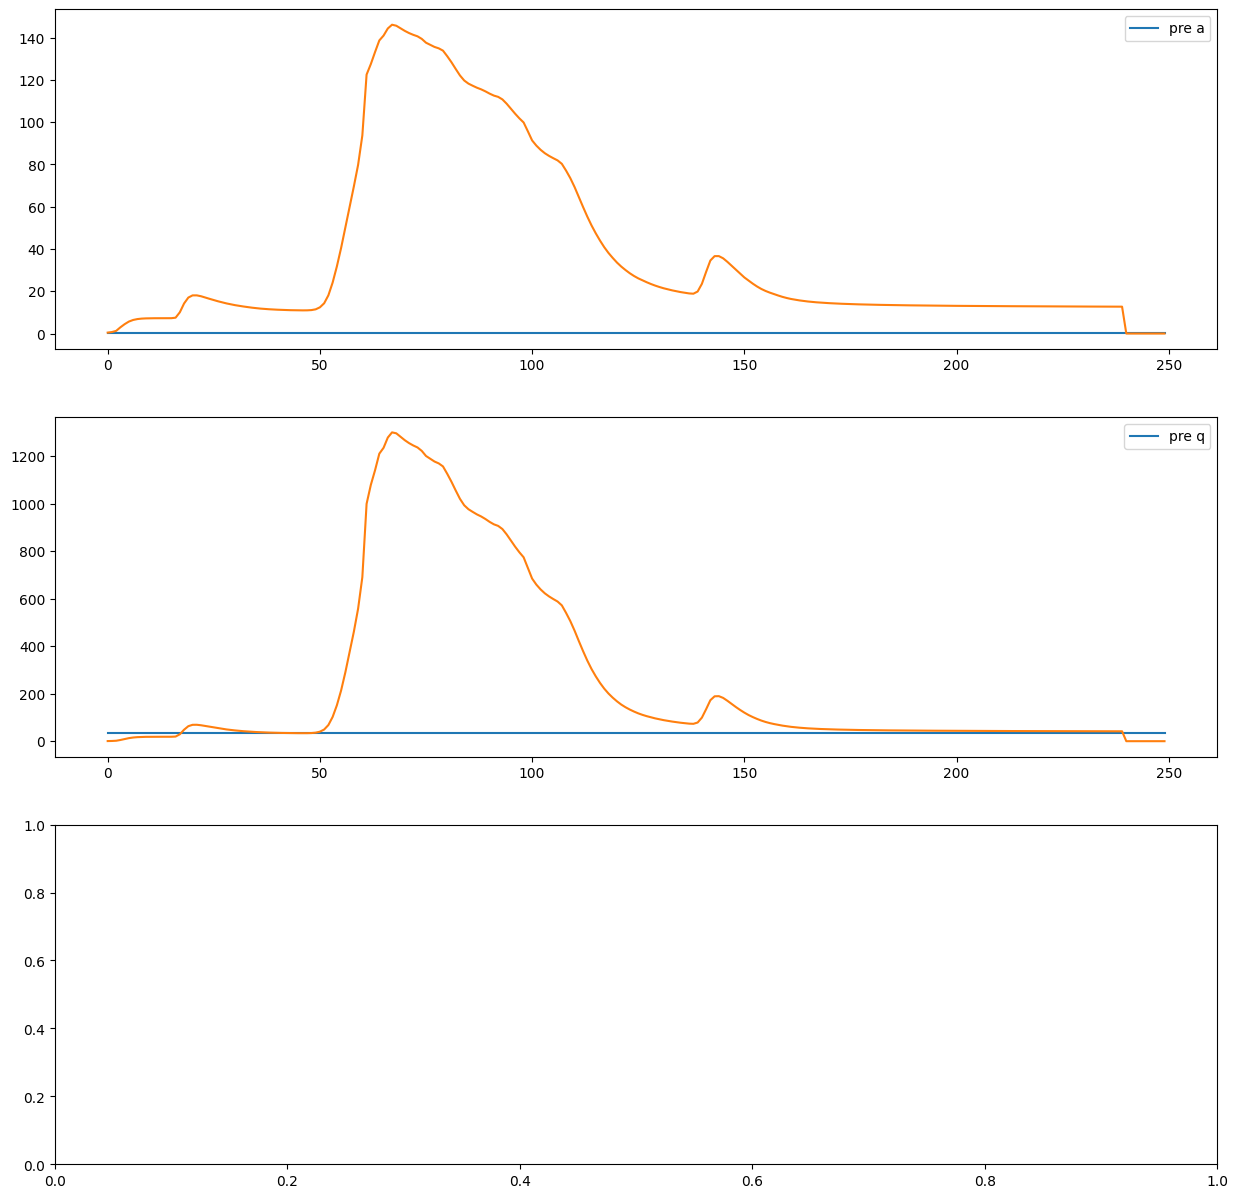

In [10]:
a, q = modelaq(torch.tensor(q_input[0:500:2,0]).to(device), 
                torch.tensor(q_input[0:500:2,1]).to(device), 
                torch.tensor(q_input[0:500:2,2]).to(device), 
                torch.tensor(q_input[0:500:2,3]).to(device),
                torch.tensor(q_input[0:500:2,4]).to(device), 
                torch.tensor(q_input[0:500:2,5]).to(device),
                torch.tensor(q_input[0:500:2,7]).to(device),
                torch.tensor(q_input[0:500:2,8]).to(device), 
                torch.tensor(q_input[0:500:2,9]).to(device), 
                torch.tensor(q_input[0:500:2,10]).to(device),
                torch.tensor(q_input[0:500:2,11]).to(device),
                torch.tensor(q_input[0:500:2,12]).to(device))

fig,ax = plt.subplots(3,1,figsize=(15,15))
ax[0].plot(a[-1].cpu().detach().numpy(),label='pre a')
ax[0].plot(a_output[0:500:2,:])
ax[0].legend()
ax[1].plot(q[-1].cpu().detach().numpy(),label='pre q')
ax[1].plot(q_output[0:500:2,:])
ax[1].legend()

#h = modelh(torch.tensor(h_input[:,0]), 
#                torch.tensor(h_input[:,1]), 
#                torch.tensor(h_input[:,2]), 
#                torch.tensor(h_input[:,3]),
#                torch.tensor(h_input[:,4]))

#ax[2].plot(h.detach().numpy(),label='pre h')
#ax[2].plot(h_output)
#ax[2].legend()

# 测试

In [194]:
# v1 parama = {'alayer':(7, 1, 20, 8),'wlayer':(2, 1, 20, 8)}
# v2 parama = {'alayer':(7, 1, 50, 10),'wlayer':(2, 1, 50, 10)}
parama = {
    'alayer':(7, 1, 3, 3),
    'wlayer':(2, 1, 3, 3)
}

paramq={
        'wlayer': (2, 1, 3, 3),
        'rlayer': (3, 1, 3, 3),
        'alayer': (4, 1, 3, 3),
        'vlayer': (2, 1, 3, 3),

        'dq1layer': (2, 1, 3, 3),
        'dq2layer': (4, 1, 3, 3),
        'dq3layer': (4, 1, 3, 3),
        'dq4layer': (4, 1, 3, 3),
        'dq5layer': (4, 1, 3, 3),
        'dq6layer': (2, 1, 3, 3),
        'qlayer':(7, 1, 3, 3),
}
modelaq = MKPS.iter_surrogate_aq(parama,paramq)

paramh = {
    'hlayer':(4, 1, 5, 5),
}

modelh = MKPS.meta_surrogate_h(paramh)

#读取
modelaq = torch.load('./surrogate_model/swmm_surogate_v2_step2')
modelh = torch.load('./surrogate_model/swmm_h_surogate_v1_step5')

# 模拟结果 （无节点水位计算）

In [195]:
def sim(t,MyNet):
    # simulation one step
    dt = 0.01
    # get all h
    h = {}
    for nodeid in [1,2,3,4,5,6]:
        h[str(nodeid)] = nodedata[str(nodeid)]['node_depth'][t]
    MyNet.nodes.set_h(h)
    
    # sim all q and a
    q_step = {}
    a_step = {}
    for j in [1,2,3,4,5]:
        a, q = modelaq(torch.tensor(MyNet.nodes.nodes_h[MyNet.connection[str(j)][0]]), 
                    torch.tensor(MyNet.nodes.nodes_z[MyNet.connection[str(j)][0]]), 
                    torch.tensor(MyNet.nodes.nodes_h[MyNet.connection[str(j)][1]]), 
                    torch.tensor(MyNet.nodes.nodes_z[MyNet.connection[str(j)][1]]),
                    torch.tensor(MyNet.links.xsect[str(j)].length), 
                    torch.tensor(MyNet.links.xsect[str(j)].sigma),
                    torch.tensor(MyNet.links.links_amid[str(j)]),
                    torch.tensor(MyNet.links.links_q[str(j)]), 
                    torch.tensor(dt), 
                    torch.tensor(MyNet.links.xsect[str(j)].yFull),
                    torch.tensor(MyNet.links.xsect[str(j)].aFull),
                    torch.tensor(MyNet.links.xsect[str(j)].rFull))

        q_step[str(j)] = q[-1].detach().numpy()[0,0]
        a_step[str(j)] = a[-1].detach().numpy()[0,0]
    MyNet.links.set_qa(q_step,a_step)
    
    
    # sim all h
    h_step = {}
    for j in [1,2,3,4,5,6]:
        qtotal = 0.0
        for linkid in MyNet.node_connection[str(j)]:
            qtotal += linkdata[str(linkid)]['link_flow'][t][0]    
        
        h = modelh(torch.tensor(MyNet.nodes.nodes_h[str(j)]), 
                torch.tensor(MyNet.nodes.nodes_z[str(j)]), 
                torch.tensor(qtotal), 
                torch.tensor(dt),
                torch.tensor(nodes_hfull[str(j)]))
        h_step[str(j)] = h[-1].detach().numpy()[0]
        
    MyNet.nodes.set_h(h_step)    
    
    return q_step,a_step,h_step

In [196]:
q, a, h = {},{},{}
for linkid in [1,2,3,4,5]:
    q[str(linkid)] = linkdata[str(linkid)]['link_flow'][:-1][0]
    a[str(linkid)] = linkdata[str(linkid)]['link_volume'][:-1][0]
for nodeid in [1,2,3,4,5,6]:
    h[str(nodeid)] = nodedata[str(nodeid)]['node_depth'][:-1][0]
MyNet.links.set_qa(q,a)
MyNet.nodes.set_h(h)
#for nodeid in [1,2,3,4,5,6]:
#    h[str(nodeid)] = nodedata[str(nodeid)]['node_depth'][:-1][0]
#MyNet.nodes.set_h(h)

Q,A,H = {}, {}, {}
for linkid in [1,2,3,4,5]:
    Q[linkid] = []
    A[linkid] = []

for nodeid in [1,2,3,4,5,6]:
    H[nodeid] = []

for t in range(T):
    q_step,a_step,h_step = sim(t,MyNet)
    for linkid in [1,2,3,4,5]:
        Q[linkid].append(q_step[str(linkid)])
        A[linkid].append(a_step[str(linkid)])
    for nodeid in [1,2,3,4,5,6]:
        H[nodeid].append(h_step[str(nodeid)])

In [197]:
er = []
for linkid in [1,2,3,4,5]:
    er += np.square(np.array(Q[linkid])-np.array(linkdata[str(linkid)]['link_flow'][1:]).T[0]).tolist()
print(np.mean(er))

er = []
for nodeid in [1,2,3,4,5,6]:
    er += np.square(np.array(H[nodeid])-np.array(nodedata[str(nodeid)]['node_depth'][1:]).T[0]).tolist()
print(np.mean(er))

0.003596326626961806
0.0002983336838024596


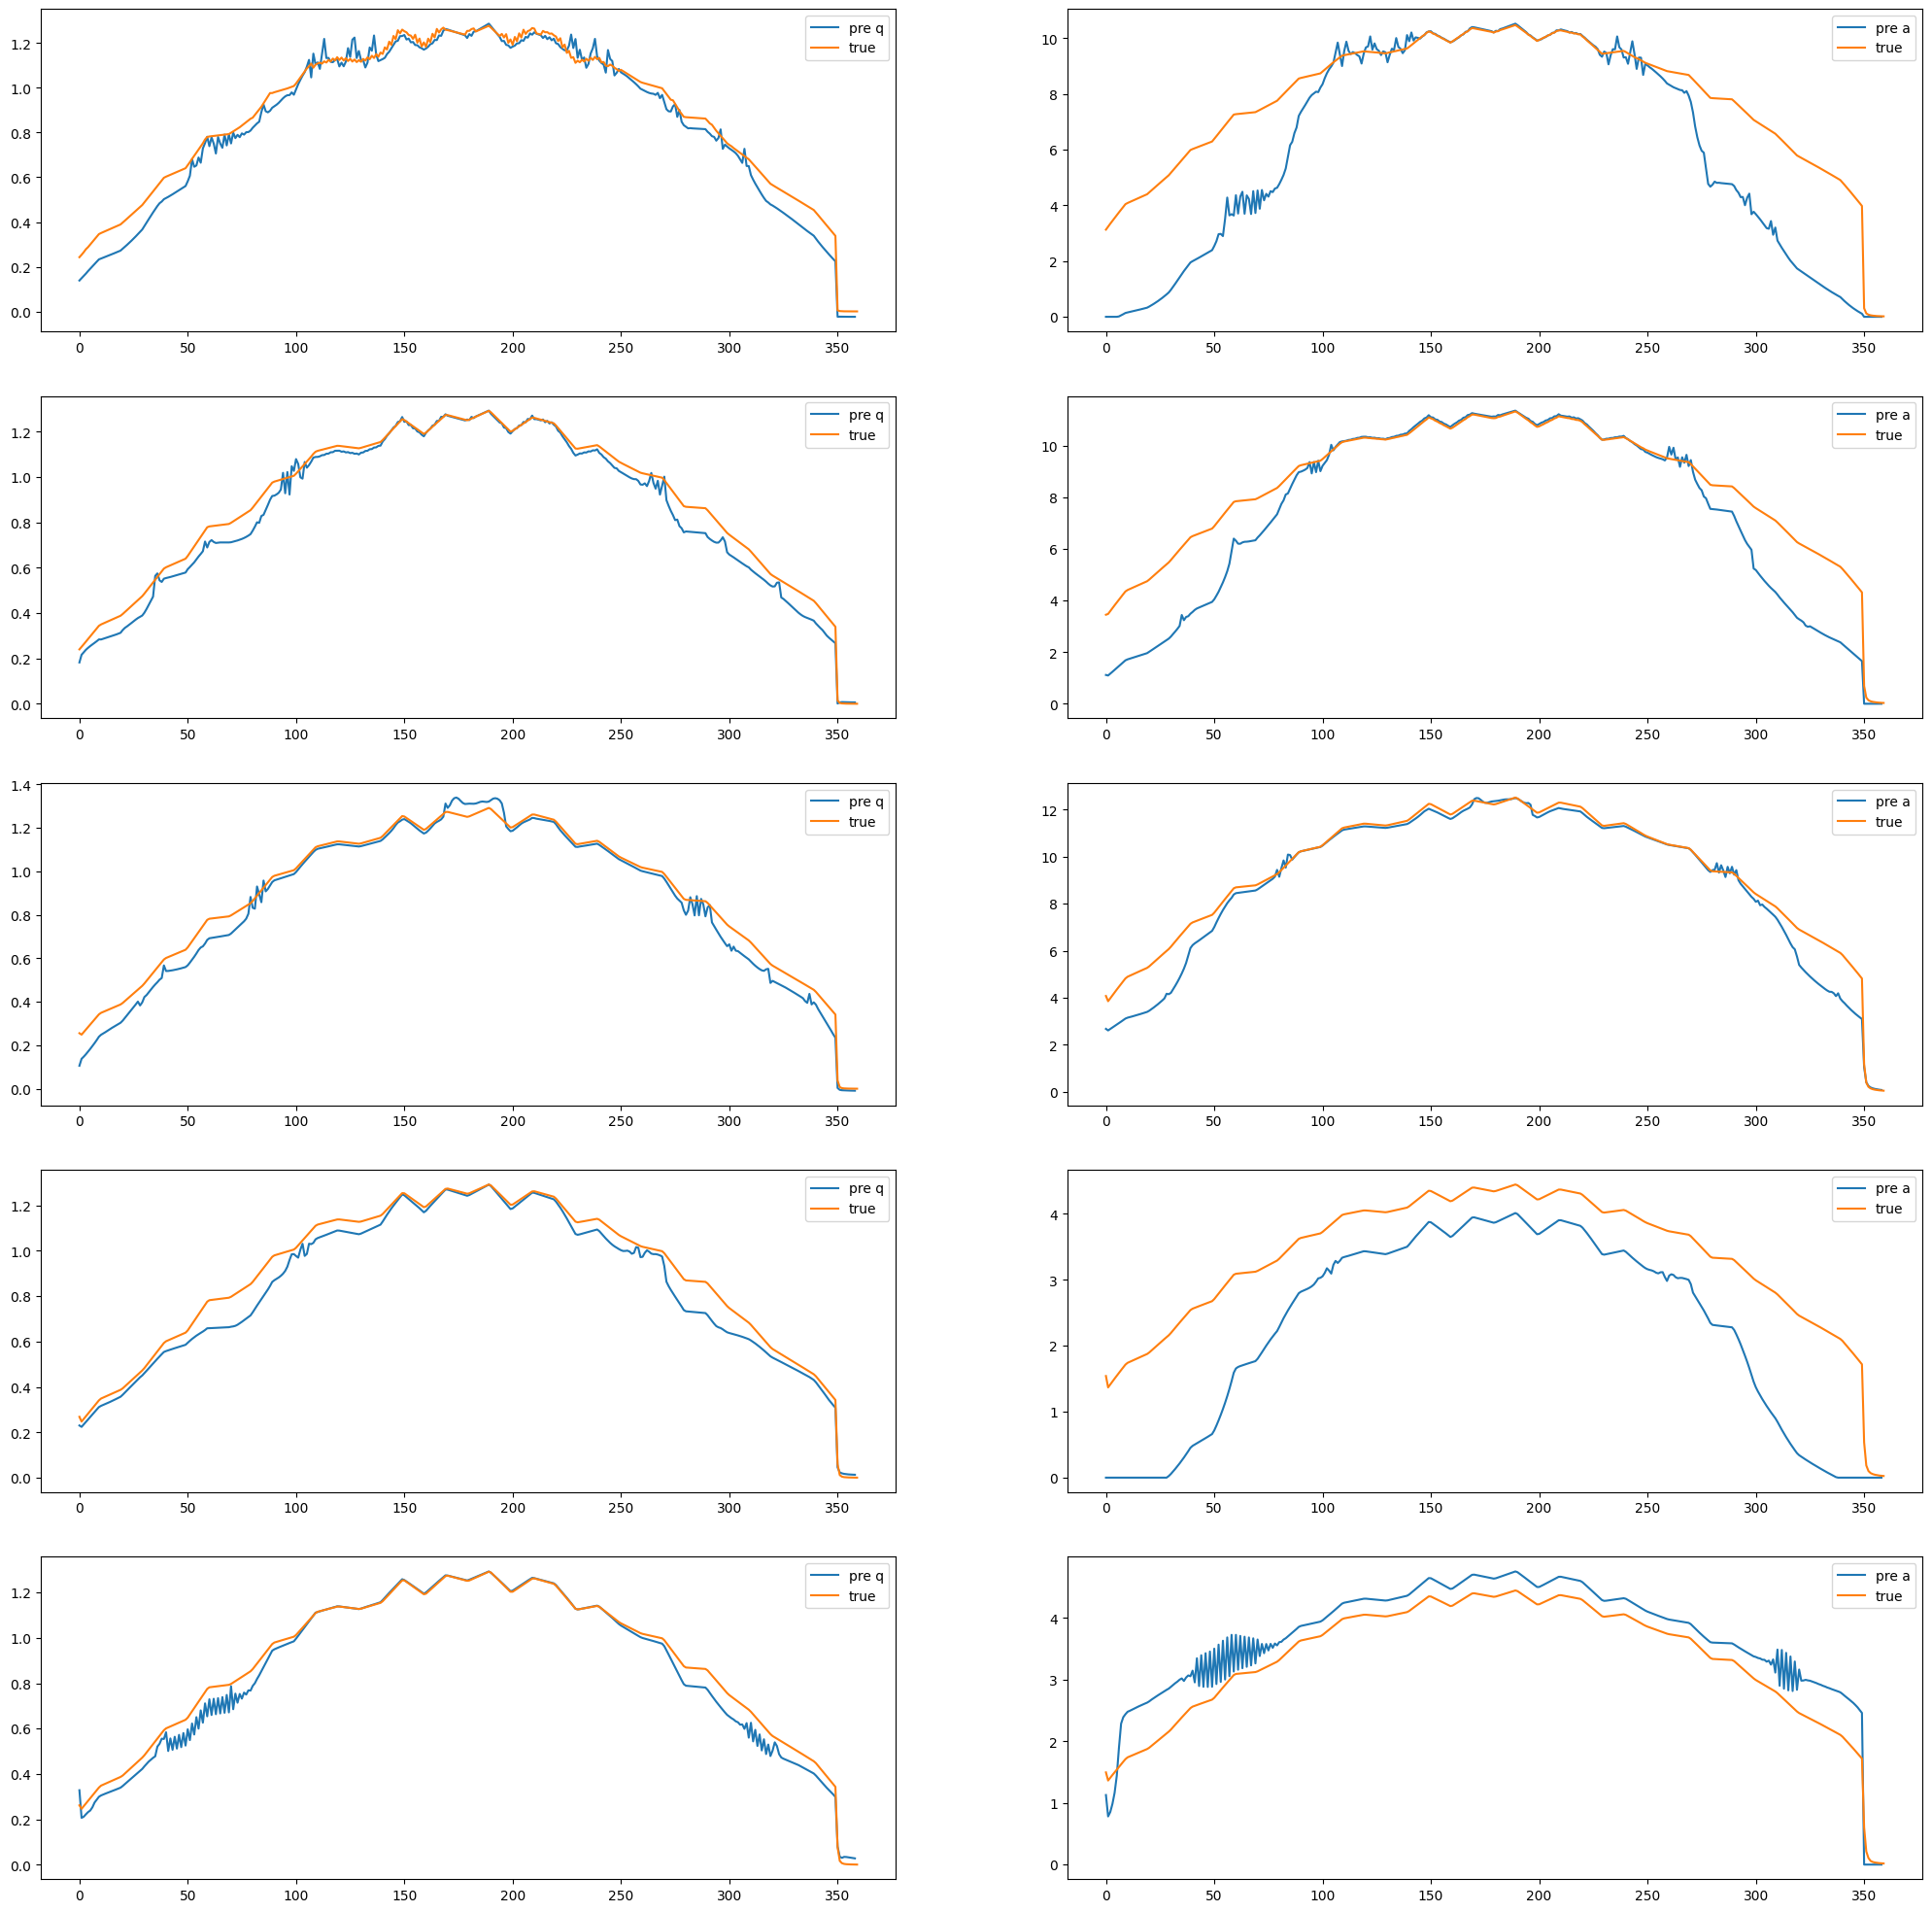

In [198]:
fig,ax = plt.subplots(5,2,figsize=(25,25))

for linkid in [1,2,3,4,5]:
    ax[linkid-1,0].plot(Q[linkid],label='pre q')
    ax[linkid-1,0].plot(linkdata[str(linkid)]['link_flow'][:],label = 'true')
    ax[linkid-1,0].legend()
    ax[linkid-1,1].plot(A[linkid],label='pre a')
    ax[linkid-1,1].plot(linkdata[str(linkid)]['link_volume'][:],label = 'true')
    ax[linkid-1,1].legend()


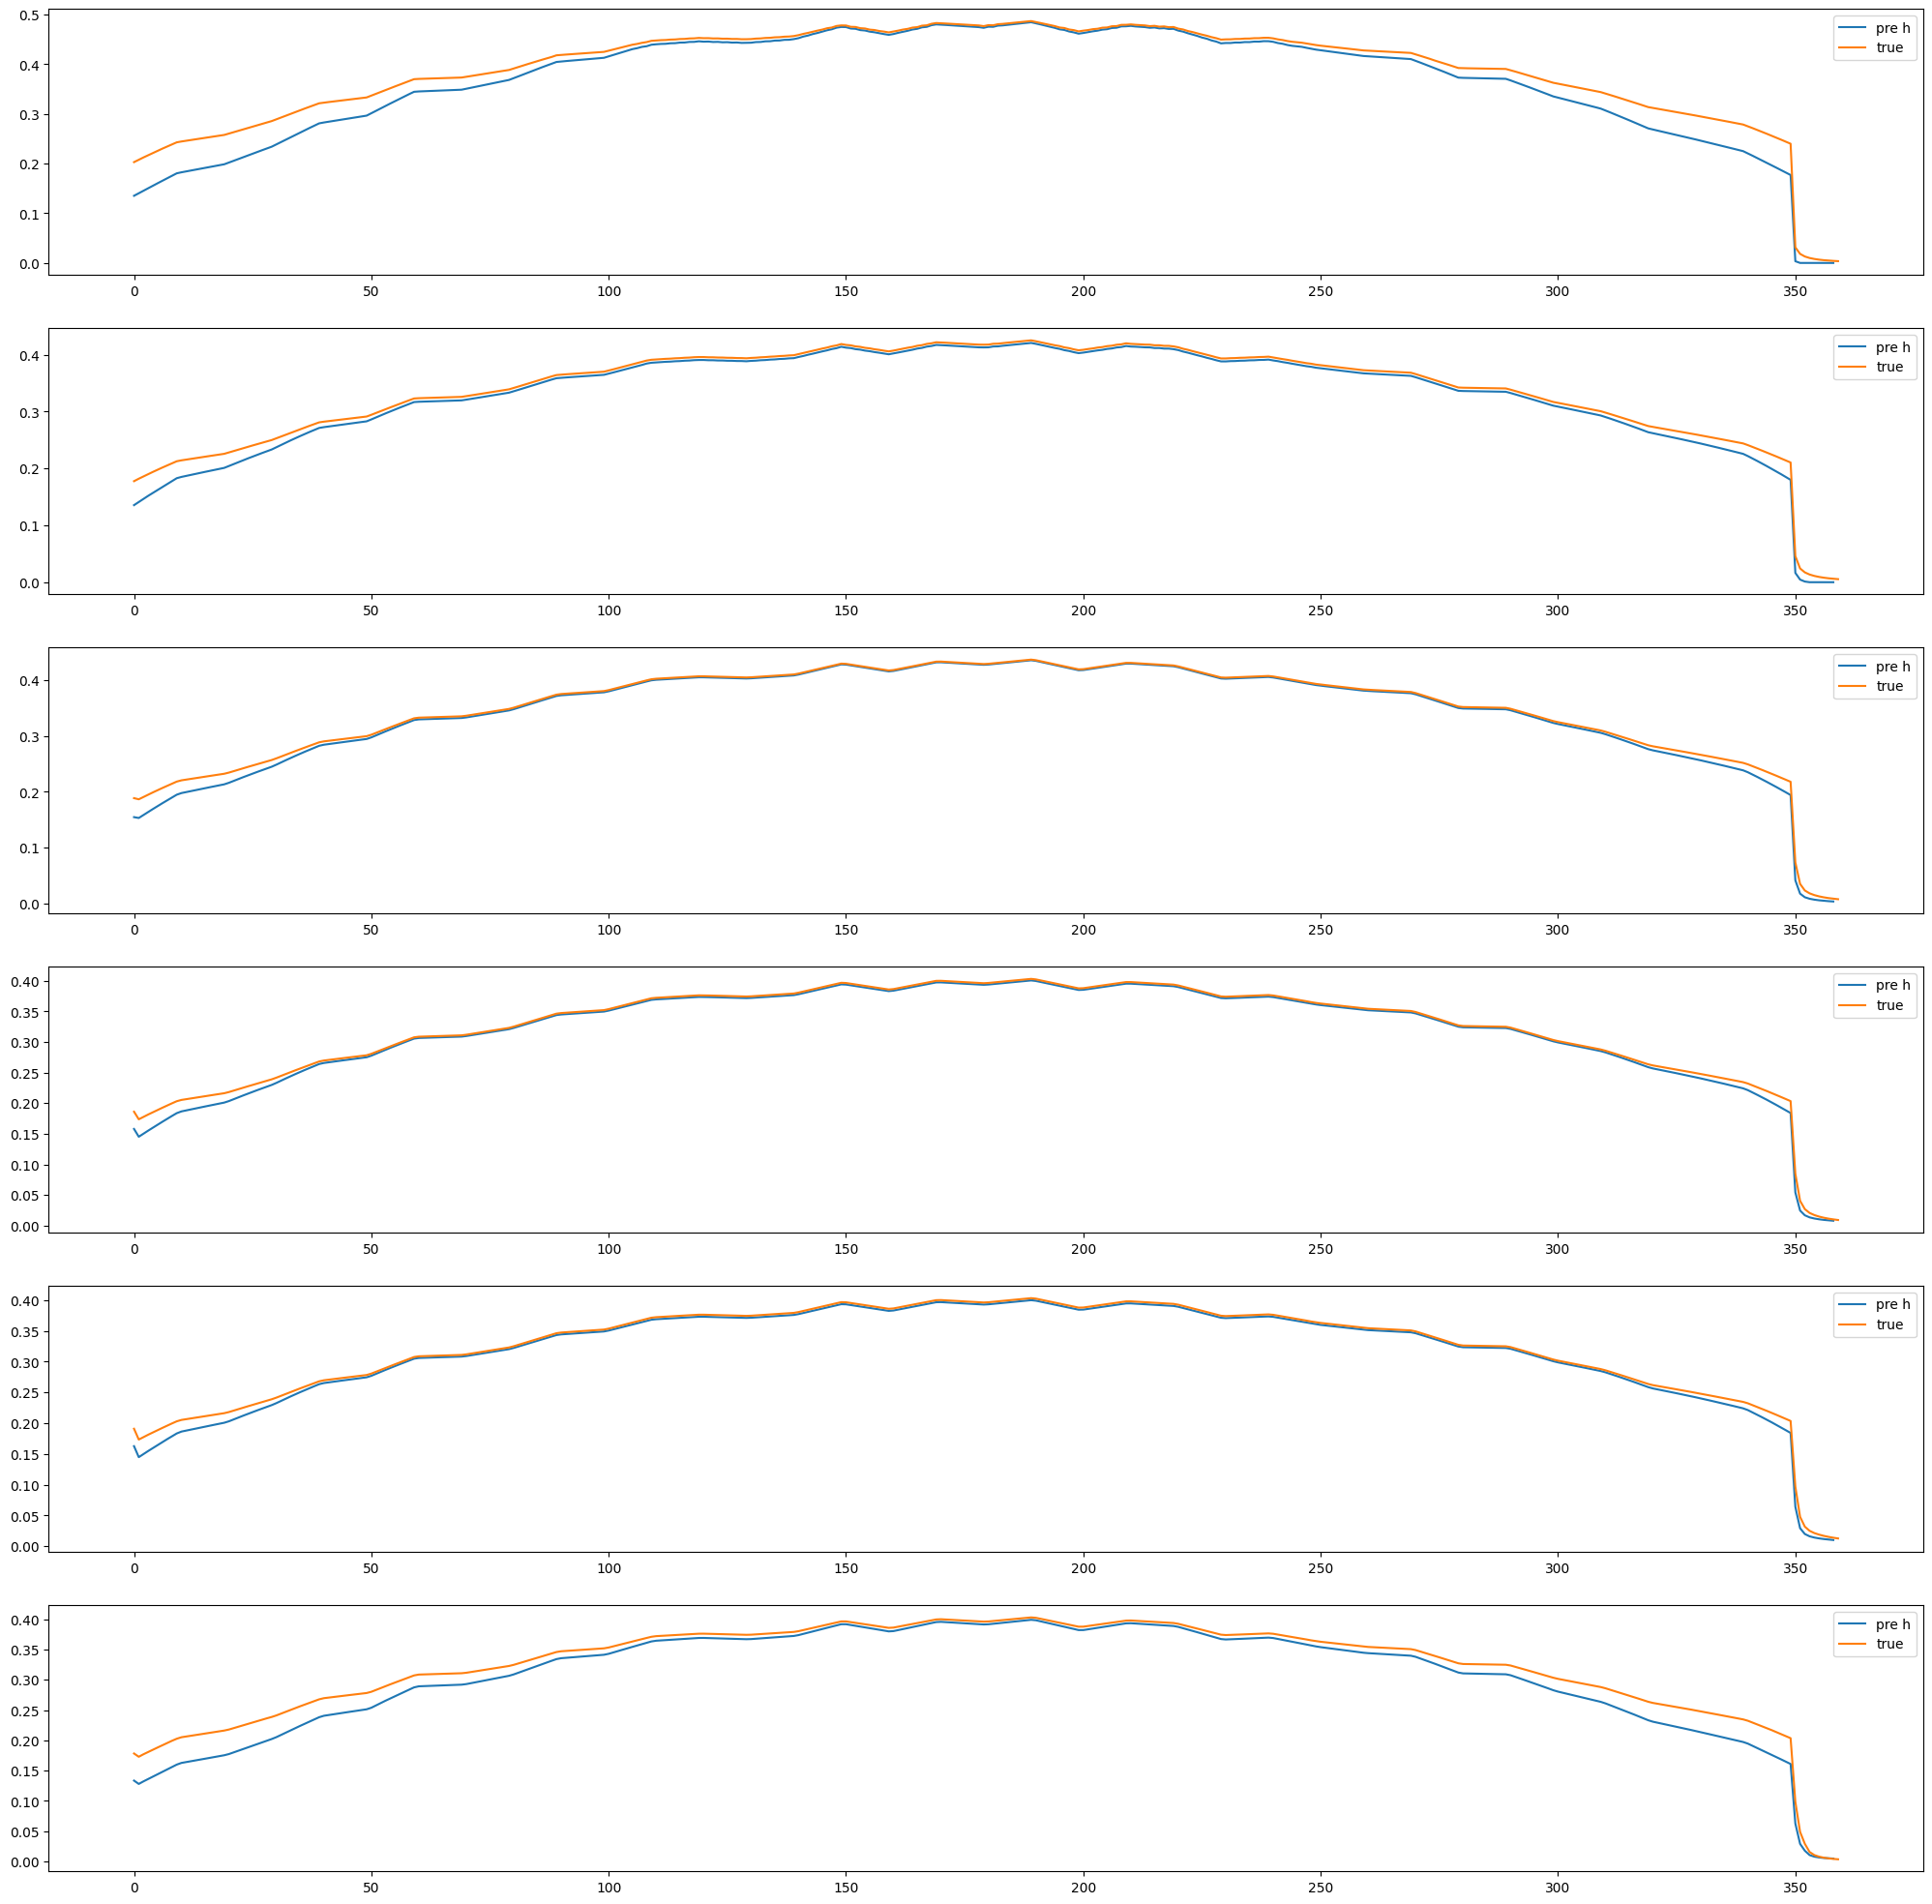

In [199]:
fig,ax = plt.subplots(6,1,figsize=(25,25))

for nodeid in [1,2,3,4,5,6]:
    ax[nodeid-1].plot(H[nodeid],label='pre h')
    ax[nodeid-1].plot(nodedata[str(nodeid)]['node_depth'][:],label = 'true')
    ax[nodeid-1].legend()